In [188]:
import pandas as pd
import seaborn as sns
import numpy as np

from tensorflow import keras
from keras import layers

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [189]:
titles = {
    'Mr.': 'mr',
    "Mrs.": 'mrs',
    "Miss.": 'miss',
    "Master.": 'master',
    'Lady': 'rare',
    'Sir.': 'rare',
    'Count': 'rare',
    'Major': 'rare',
    'Don.': 'rare',
    'Dr.': 'rare',
    'Rev.': 'rare',
    'Col.': 'rare',
    'Ms': 'mrs',
    'Mme.': 'rare',
    'Mlle.': 'miss',
    'Capt.': 'rare',
    'Jonkheer.': 'rare',
    'Dona.': 'mrs'
}
# titles = {
#     'Mr.': 0,
#     "Mrs.": 1,
#     "Miss.": 2,
#     "Master.": 3,
#     'Lady': 4,
#     'Sir.': 4,
#     'Count': 4,
#     'Major': 4,
#     'Don.': 4,
#     'Dr.': 4,
#     'Rev.': 4,
#     'Col.': 4,
#     'Ms': 1,
#     'Mme.': 4,
#     'Mlle.': 2,
#     'Capt.': 4,
#     'Jonkheer.': 4,
#     'Dona.': 1
# }
df['title'] = 0
df_test['title'] = 0
for i, name in enumerate(df['Name']):
    for key in titles:
        if key in name:
            df['title'].iloc[i] = titles[key]
for i, name in enumerate(df_test['Name']):
    for key in titles:
        if key in name:
            df_test['title'].iloc[i] = titles[key]

/tmp/ipykernel_29765/3948701475.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'].iloc[i] = titles[key]
/tmp/ipykernel_29765/3948701475.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['title'].iloc[i] = titles[key]


In [190]:
mask = [True if 'master' in item else False for item in df['Name'].apply(str).str.lower()]
mask2 = df['Age'].isnull()
df.loc[mask & mask2, 'Age'] = 10

In [191]:
mask = [True if 'mr.' in item else False for item in df['Name'].apply(str).str.lower()]
mask2 = df['Age'].isnull()
df.loc[mask & mask2, 'Age'] = df.loc[df['Sex'] == 'male', 'Age'].median()

In [192]:
df.loc[df['Age'].isnull(), 'Age'] = df.loc[df['Sex'] == 'female', 'Age'].median()

In [193]:
mask = [True if 'master' in item else False for item in df_test['Name'].apply(str).str.lower()]
mask2 = df_test['Age'].isnull()
df_test.loc[mask & mask2, 'Age'] = 10

In [194]:
mask = [True if 'mr.' in item else False for item in df_test['Name'].apply(str).str.lower()]
mask2 = df_test['Age'].isnull()
df_test.loc[mask & mask2, 'Age'] = df_test.loc[df_test['Sex'] == 'male', 'Age'].median()
df_test.loc[df_test['Age'].isnull(), 'Age'] = df_test.loc[df_test['Sex'] == 'female', 'Age'].median()

<AxesSubplot:xlabel='Fare', ylabel='Count'>

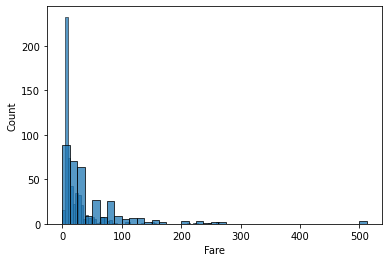

In [195]:
df_test['Fare'].fillna(df_test['Fare'].median(), inplace = True)
sns.histplot(x = df.loc[df['Survived'] == 0, 'Fare'])
sns.histplot(x = df.loc[df['Survived'] == 1, 'Fare'])

In [196]:
func = lambda x: x[0]
for dataf in [df, df_test]:
    minor = dataf['Age'] < 6
    teen = dataf['Age'] >= 6
    adult = dataf['Age'] >= 20
    elder = dataf['Age'] >= 60
    poor = dataf['Fare'] <= 20
    middle = dataf['Fare'] <= 50
    rich = dataf['Fare'] > 50
    dataf.loc[minor, 'Age'] = 'minor'
    dataf.loc[teen, 'Age'] = 'teen'
    dataf.loc[adult, 'Age'] = 'adult'
    dataf.loc[elder, 'Age'] = 'elder'
    dataf.loc[rich, 'Fare'] = 'rich'
    dataf.loc[middle, 'Fare'] = 'middle'
    dataf.loc[poor, 'Fare'] = 'poor'
#     dataf['Age'].fillna('missing', inplace=True)
    dataf['relatives'] = dataf['SibSp'] + dataf['Parch']
    alone = (dataf['relatives'] == 0)
    survivor = (dataf['relatives'] > 0)
    dead_man = (dataf['relatives'] > 4)
    dataf.loc[alone, 'relatives'] = 'alone'
    dataf.loc[survivor, 'relatives'] = 'survivor'
    dataf.loc[dead_man, 'relatives'] = 'dead_man'
    dataf["Embarked"].fillna('S', inplace=True)
    dataf['Cabin'] = dataf['Cabin'].apply(str).apply(func)
#     dataf['Fare'] = dataf['Fare'].astype(int)

In [197]:
y = df.pop('Survived')

In [198]:
# cat_features = ['Pclass', 'Sex', 'Embarked', \
#                 'Age', 'relatives', 'Cabin', 'title']
# cat_features = ['Sex', 'Embarked', 'Age', 'relatives', 'Cabin', 'Fare', 'Pclass', 'title']
cat_features = ['Sex', 'Embarked', 'Age', 'relatives', 'Fare', 'Pclass', 'title']
features_to_drop = ['Ticket', 'Name', 'SibSp', 'Parch', 'PassengerId', 'Cabin']
X = df.drop(features_to_drop, axis=1)
X_test = df_test.drop(features_to_drop, axis=1)

In [199]:
mask = [True if 'T' in item else False for item in X['Cabin'].apply(str)]
X.loc[mask, 'Cabin'] = 'n'

KeyError: 'Cabin'

In [200]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def keras_classifier_wrapper():
    clf = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, input_shape=[23], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return clf

clf = keras_classifier_wrapper()

X = pd.get_dummies(X, columns=cat_features)
X_test = pd.get_dummies(X_test, columns=cat_features)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)
train_X.shape

(712, 23)

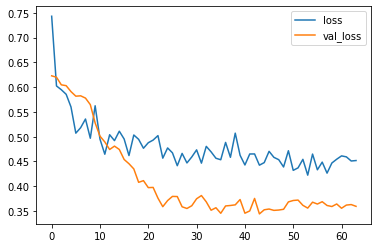

In [201]:
from keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

history = clf.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=64,
    epochs=200,
    verbose=0,
    callbacks=[callbacks],
    shuffle=True)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [202]:
predictions = clf.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [203]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived'] = pd.DataFrame(predictions.round())
submission['Survived'] = submission['Survived'].apply(int)
submission.to_csv('nn_seven_try.csv', index=False)

In [204]:
submission['Survived'].sum()

132

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier(random_state=11)
grid = {'max_leaf_nodes': [110],
       'n_estimators': [1900],
       'max_features': [6],
       'max_depth': [9]}
model = GridSearchCV(rf_clf, grid, cv=10, scoring='accuracy', n_jobs=-1)

In [206]:
model.fit(train_X, train_y)
predictions = model.predict(test_X)

In [207]:
print(f"gridsearch best_score = {model.best_score_:0.3f}")
print(f"gridsearch best parameters = {model.best_params_}")
print(classification_report(test_y, predictions))

gridsearch best_score = 0.791
gridsearch best parameters = {'max_depth': 9, 'max_features': 6, 'max_leaf_nodes': 110, 'n_estimators': 1900}
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       110
           1       0.92      0.71      0.80        69

    accuracy                           0.87       179
   macro avg       0.88      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179



In [209]:
predictions = model.predict(X_test)

In [210]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived'] = predictions
submission.to_csv("rf_model.csv", index=False)